Creating Paths

In [1]:
import os

In [5]:
main_path_str = "chest_xray"
train_path = os.path.join(main_path_str, "train")
test_path = os.path.join(main_path_str, "test")
val_path = os.path.join(main_path_str, "val")

Loading Images

In [6]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

2023-02-15 16:27:56.978644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
classes = os.listdir(train_path)
classes

['PNEUMONIA', 'NORMAL']

In [26]:
train_images_normal = tf.data.Dataset.list_files(train_path + "/NORMAL/*.jpeg", shuffle=True)
train_images_pneumonia = tf.data.Dataset.list_files(train_path + "/PNEUMONIA/*.jpeg", shuffle=True)

In [42]:
def load_image(filepath):
    img_size = 256
    
    byte_img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, [img_size, img_size])
    
    return img

In [43]:
train_images_normal_mapped = train_images_normal.map(load_image)
train_images_pneumonia_mapped = train_images_pneumonia.map(load_image)

Visualize Images

In [44]:
import random

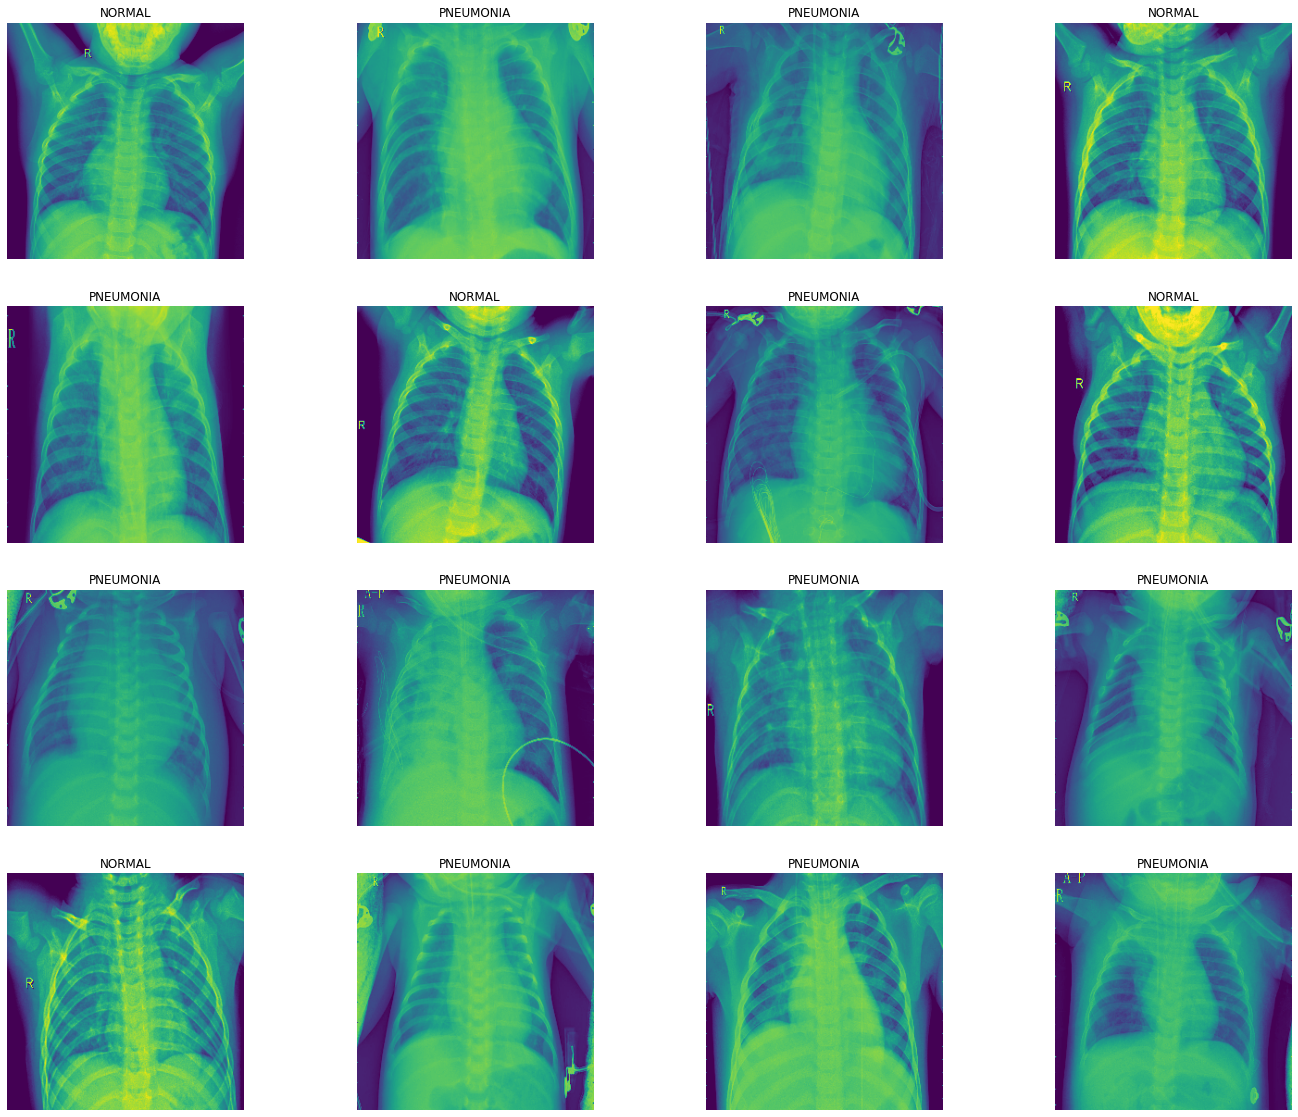

In [223]:
plt.figure(figsize=(24,20))

for idx in range(16):
    class_name = random.choice(classes)
    class_dir = os.path.join(train_path, class_name)
    file = random.choice(os.listdir(class_dir))
    filepath = os.path.join(class_dir, file)
    
    image = load_image(filepath)
    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    plt.axis(False)
    plt.title(f"{class_name}")

Preprocessing

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG 

In [51]:
def grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [205]:
image_size = (256, 256)
batch_size = 32

train_datagen = IDG(rescale=1./255, preprocessing_function=grayscale)
test_datagen = IDG(rescale=1./255, preprocessing_function=grayscale)
val_datagen = IDG(rescale=1./255, preprocessing_function=grayscale)

train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=image_size,
                                               batch_size=batch_size,
                                               class_mode="binary",
                                               shuffle=True)

test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=image_size,
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=False)

val_data = val_datagen.flow_from_directory(val_path,
                                            target_size=image_size,
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Model

In [101]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, MaxPool2D, Flatten
from keras.applications import ResNet152
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Recall, Precision

In [96]:
def build_model():
    input_layer = Input(shape=(256,256,3))
    
    ResNet = ResNet152(include_top=False)(input_layer)
    
    model = Conv2D(32, (3,3), activation='relu', padding="same", name='conv2d_1')(ResNet)
    model = Conv2D(64, (3,3), activation='relu', name='conv2d_2')(model)
    model = MaxPool2D(name='pool_1')(model)
    model = Conv2D(64, (3,3), activation='relu', name='conv2d_3')(model)
    model = Flatten(name='flatten')(model)
    outputs = Dense(1, activation='sigmoid', name='output_layer')(model)
    
    resnet_model = Model(inputs=input_layer, outputs=outputs)
    return resnet_model

In [97]:
resnet_model = build_model()
resnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          589856    
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 3, 3, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 64)                0   

In [98]:
batches_per_epoch = len(train_data)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [99]:
opt = Adam(learning_rate=0.0001, decay=lr_decay)

In [102]:
resnet_model.compile(loss=BinaryCrossentropy(),
                     optimizer=opt,
                     metrics=["Precision", "Recall"])

Training Model

In [104]:
logdir = "Logs"

In [106]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [107]:
history = resnet_model.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tensorboard_callback])

Epoch 1/5
163/163 [==============================] - 7231s 44s/step - loss: 0.0677 - precision: 0.9853 - recall: 0.9830 - val_loss: 1.3911 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/5
163/163 [==============================] - 7413s 45s/step - loss: 0.0179 - precision: 0.9961 - recall: 0.9951 - val_loss: 1.4465 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/5
163/163 [==============================] - 6351s 39s/step - loss: 0.0085 - precision: 0.9979 - recall: 0.9977 - val_loss: 1.0036 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/5
163/163 [==============================] - 6307s 39s/step - loss: 0.0045 - precision: 0.9987 - recall: 0.9990 - val_loss: 1.4708 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/5
163/163 [==============================] - 6344s 39s/step - loss: 0.0026 - precision: 0.9997 - recall: 0.9990 - val_loss: 2.0942 - val_precision: 0.6250 - val_recall: 1.0000


Analysing Model

In [108]:
history.history

{'loss': [0.06765864789485931,
  0.01793479546904564,
  0.008452811278402805,
  0.004494504537433386,
  0.0026378710754215717],
 'precision': [0.9852560758590698,
  0.9961250424385071,
  0.9979349374771118,
  0.998710036277771,
  0.9997417330741882],
 'recall': [0.982967734336853,
  0.9950968027114868,
  0.9976774454116821,
  0.9989677667617798,
  0.9989677667617798],
 'val_loss': [1.3910773992538452,
  1.4464510679244995,
  1.0035994052886963,
  1.4707566499710083,
  2.0942366123199463],
 'val_precision': [0.625, 0.625, 0.625, 0.625, 0.625],
 'val_recall': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [111]:
result = resnet_model.evaluate(test_data, verbose=0)
print(f'Loss: {result[0]}\nPrecision: {result[1]}\nRecall: {result[2]}')

Loss: 2.0942366123199463
Precision: 0.625
Recall: 1.0


In [170]:
def plot(metric=str):
    plt.figure(figsize=(8,6))
    
    plt.plot(history.history[metric], color="teal", label=metric)
    plt.plot(history.history["val_" + metric], color="orange", label="val " + metric)
    plt.title(metric)
    plt.legend()
    
    plt.show()

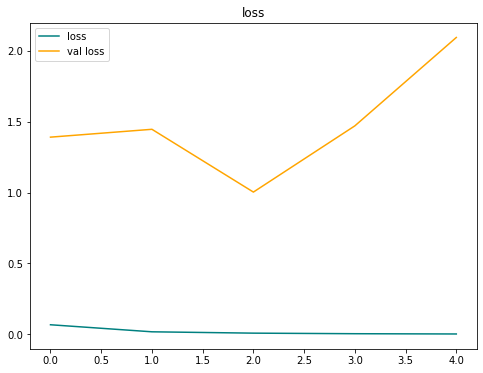

In [171]:
plot("loss")

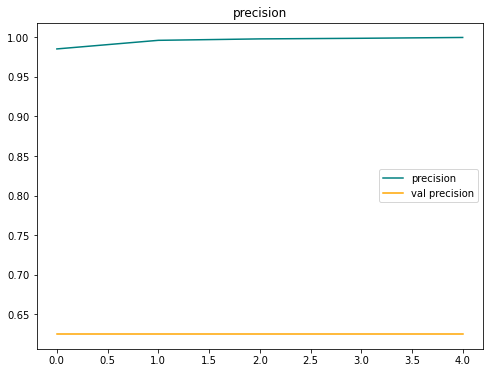

In [172]:
plot("precision")

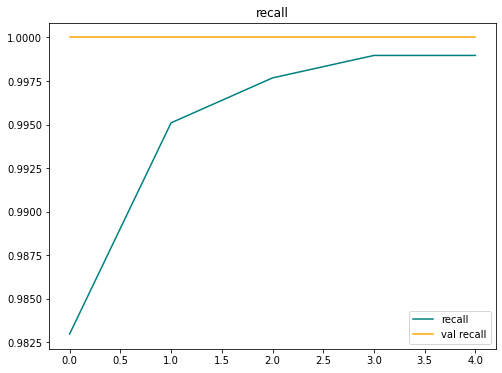

In [173]:
plot("recall")

Classification Report

In [206]:
y_test = val_data.classes
y_pred = resnet_model.predict(val_data)
y_pred_probs = y_pred.copy()

1/1 [==============================] - 4s 4s/step


In [207]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [208]:
from sklearn.metrics import classification_report

In [209]:
print(classification_report(y_test,y_pred,target_names=classes))

              precision    recall  f1-score   support

   PNEUMONIA       0.00      0.00      0.00         8
      NORMAL       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liranpod/miniconda3/envs/experimental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [210]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

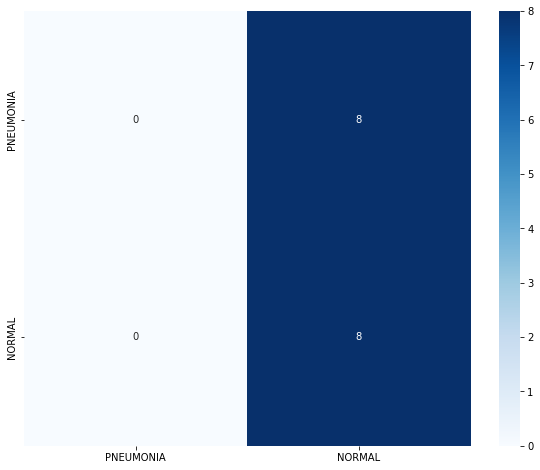

In [211]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=classes,
            yticklabels=classes,cmap='Blues')
plt.show()

Making Predictions

In [215]:
from PIL import Image

chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


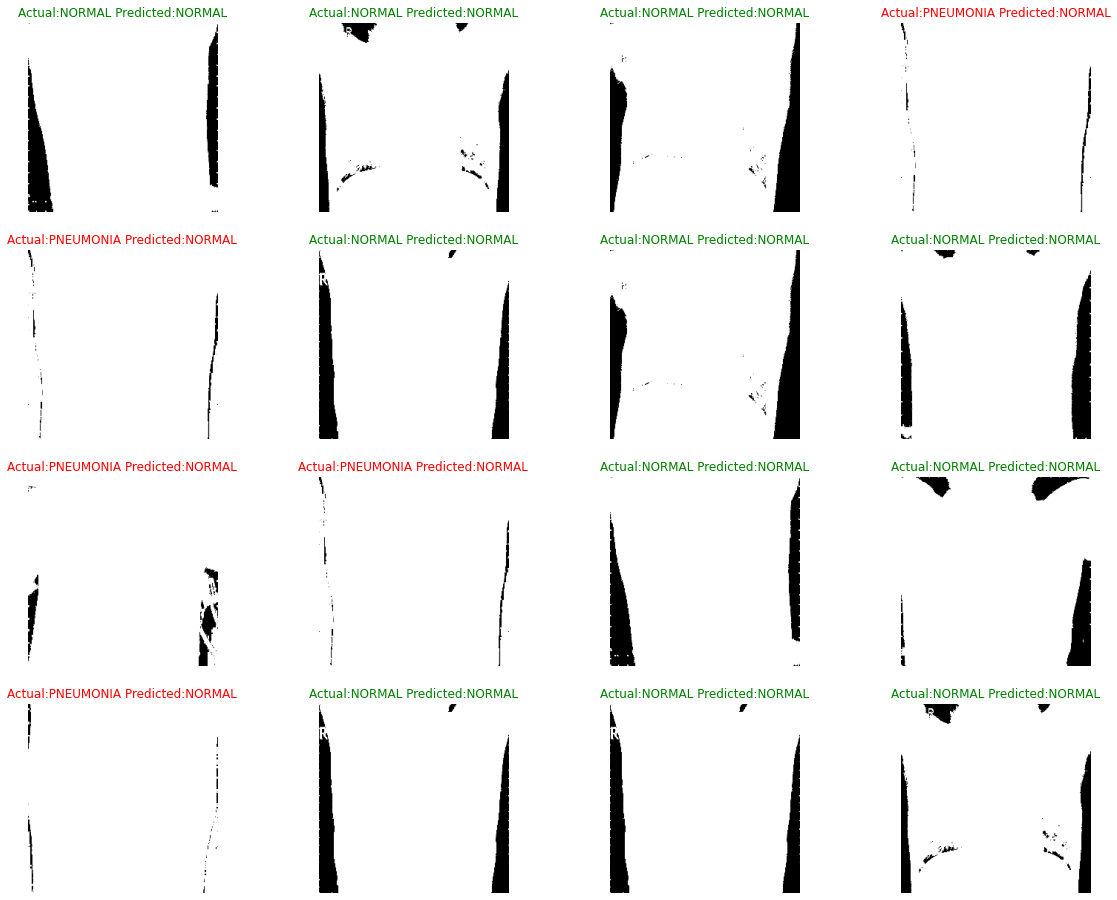

In [226]:
plt.figure(figsize=(20,16))
for idx in range(16):
    class_name = random.choice(classes)
    
    while True:
        filename = random.choice(os.listdir(val_path + "/" + class_name))
        if filename != '.DS_Store': break
    filepath = val_path + "/" + class_name + "/" + filename
    print(filepath)
    
    image = load_image(filepath)
    image = tf.reshape(tf.broadcast_to(image, (256, 256, 3)),  (256, 256, 3)) # Shouldn't need this - 
    #                                                                           unsure why images are 1 channel.

    pred_prob = resnet_model.predict(np.expand_dims(image, axis=0), verbose=0)
    
    
    pred_prob = resnet_model.predict(tf.expand_dims(image, axis=0), verbose=0)
    pred = 1 if pred_prob[0][0] > 0.5 else 0 
    pred_class = classes[pred]

    plt.subplot(4, 4, idx+1)
    plt.imshow(image)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual:{class_name} Predicted:{pred_class}", c=title_color)
    plt.axis(False)

In [227]:
# To fix this code - input layer of model should have been (256, 256, 1).